In [1]:
from datetime import datetime, timedelta

from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
DATA = '../data'
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 10, 22)

In [3]:
sp = yf.download(
    '^GSPC', start='1950-01-01', end=str(TOMORROW)).sort_index()
nyse = yf.download(
    '^NYA', start='1965-01-01', end=str(TOMORROW)).sort_index()
nas = yf.download(
    '^IXIC', start='1965-01-01', end=str(TOMORROW)).sort_index()
wil = yf.download(
    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
sp.to_csv(f'{path}/sp1950.csv')
nyse.to_csv(f'{path}/nya1965.csv')
nas.to_csv(f'{path}/nasdaq1965.csv')
wil.to_csv(f'{path}/wilshire1990.csv')

#sp = pd.read_csv(f'{DATA}/sp1950.csv')
#nyse = pd.read_csv(f'{DATA}/nya1965.csv')
#nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
#wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
sp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [5]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.01140459, 1.00474777, ..., 0.9933279 , 0.99204909,
       1.02372482])

In [6]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [7]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.index)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [8]:
[sp, nyse, nas, wil] = [
    prep_df(df, name) 
    for df, name in zip(
        [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

,sp,sp_daily
Date,,
1950-01-03,16.66,1.000000
1950-01-04,16.85,1.011405
1950-01-05,16.93,1.004748
1950-01-06,16.98,1.002953
1950-01-09,17.08,1.005889


In [9]:
nyse.head()

,nyse,nyse_daily
Date,,
1965-12-31,528.690002,1.000000
1966-01-03,527.210022,0.997201
1966-01-04,527.840027,1.001195
1966-01-05,531.119995,1.006214
1966-01-06,532.070007,1.001789


In [10]:
nas.head()

,nas,nas_daily
Date,,
1971-02-05,100.000000,1.000000
1971-02-08,100.839996,1.008400
1971-02-09,100.760002,0.999207
1971-02-10,100.690002,0.999305
1971-02-11,101.449997,1.007548


In [11]:
def find_best_mod(daily, n_states=[6, 7, 8], max_iter=1000):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = -np.inf
    best_mod = None
    for states in n_states:
        mod = GaussianHMM(
            n_components=states, n_iter=max_iter
        ).fit(daily)
        logprob = mod.score(daily)
        if logprob > best_logprob:
            print(f'New best - States: {states}')
            best_logprob = logprob
            best_mod = mod
    return best_mod

In [12]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [13]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.axhline(y=1, color='k')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [14]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

New best - States: 5
New best - States: 6
0.9999782953511035


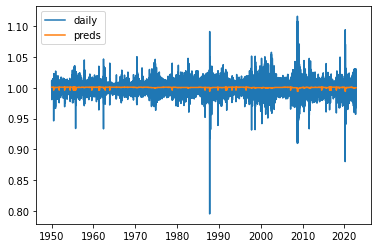

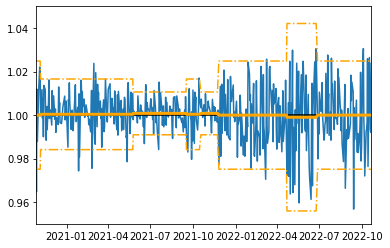

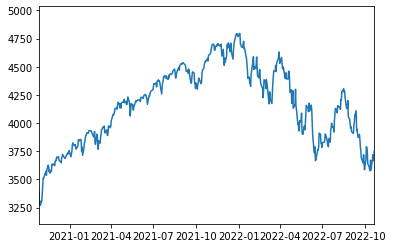

In [15]:
sp_mod = find_best_mod(sp.sp_daily, n_states=[5, 6, 7])
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

New best - States: 7
New best - States: 9
1.000448190712378


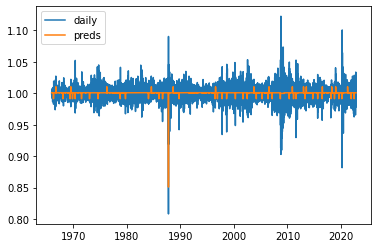

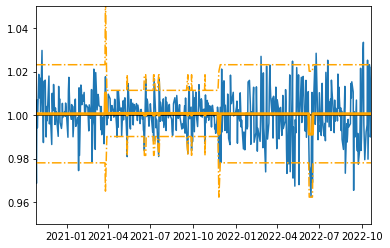

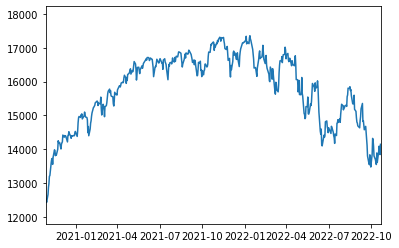

In [37]:
nyse_mod = find_best_mod(nyse.nyse_daily, n_states=[7, 8, 9, 10])
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

New best - States: 8
New best - States: 9
1.0004533376764038


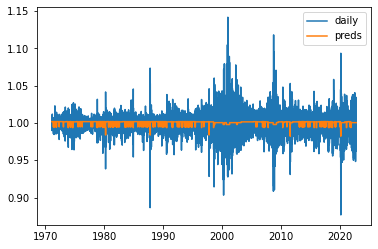

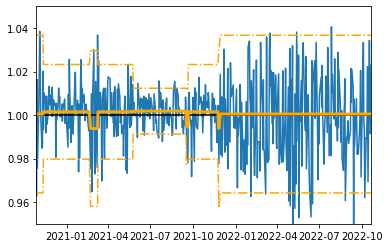

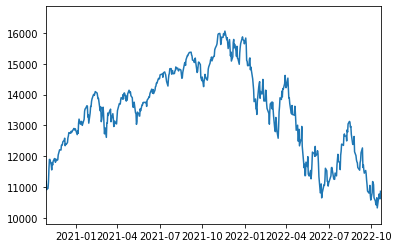

In [17]:
nas_mod = find_best_mod(nas.nas_daily, n_states=[8, 9, 10])
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

New best - States: 8
New best - States: 9
1.0003156666642716


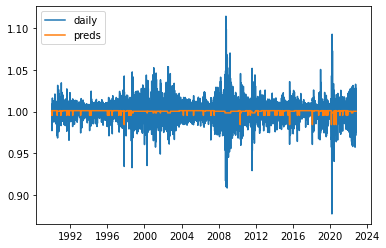

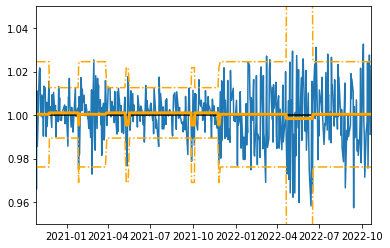

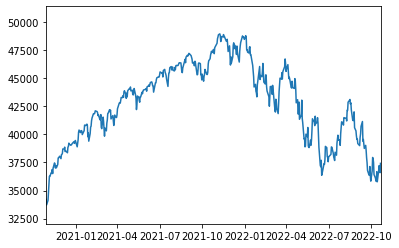

In [18]:
wil_mod = find_best_mod(wil.wil_daily, n_states=[8, 9, 10])
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [38]:
mean_states = (6 + 9 + 9 + 9) / 4
mean_states

8.25

In [56]:
N_STATES = 8

In [39]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

1.0002988726010393

In [40]:
for df, name, exp in zip(
        [sp, nyse, nas, wil],
        ['sp', 'nyse', 'nas', 'wil'],
        [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_38103/3186342578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{name}_exp'] = exp


In [41]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp
Date,,,,,,,,,,,,
2022-10-17,3677.949951,1.026480,0.99998,13923.209961,1.023215,1.000602,10675.799805,1.034337,1.000466,36766.960938,1.027624,1.000347
2022-10-18,3719.979980,1.011428,0.99998,14089.200195,1.011922,1.000602,10772.400391,1.009049,1.000466,37213.648438,1.012149,1.000347
2022-10-19,3695.159912,0.993328,0.99998,13947.259766,0.989926,1.000602,10680.509766,0.991470,1.000466,36882.570312,0.991103,1.000347
2022-10-20,3665.780029,0.992049,0.99998,13840.469727,0.992343,1.000602,10614.839844,0.993851,1.000466,36589.851562,0.992063,1.000347
2022-10-21,3752.750000,1.023725,0.99998,14144.051758,1.021934,1.000602,10859.715820,1.023069,1.000466,37419.429688,1.022672,1.000347


In [42]:
df['mean_exp'] = (
    df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1))

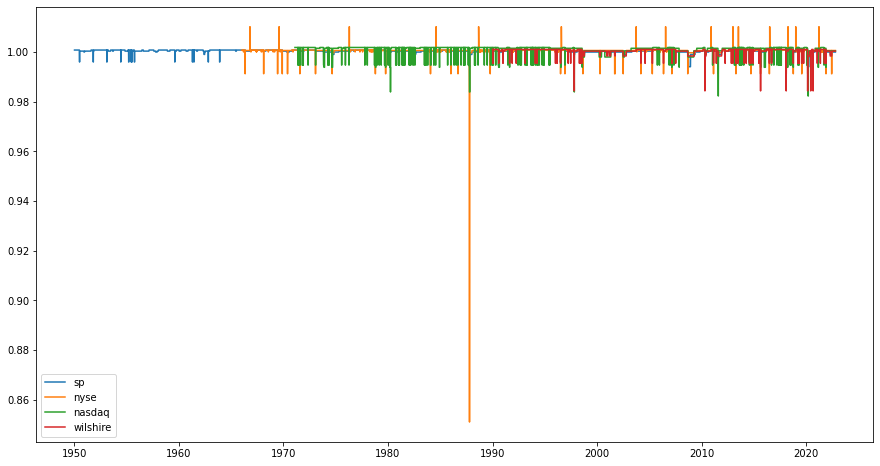

In [43]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

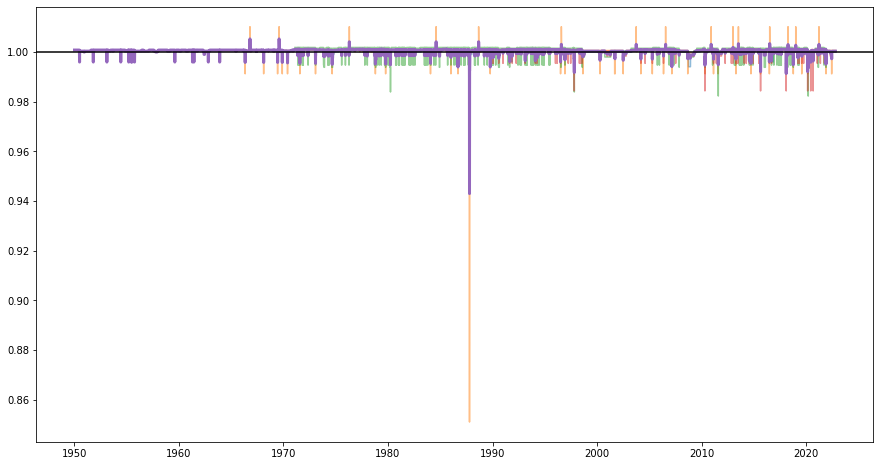

In [44]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k');

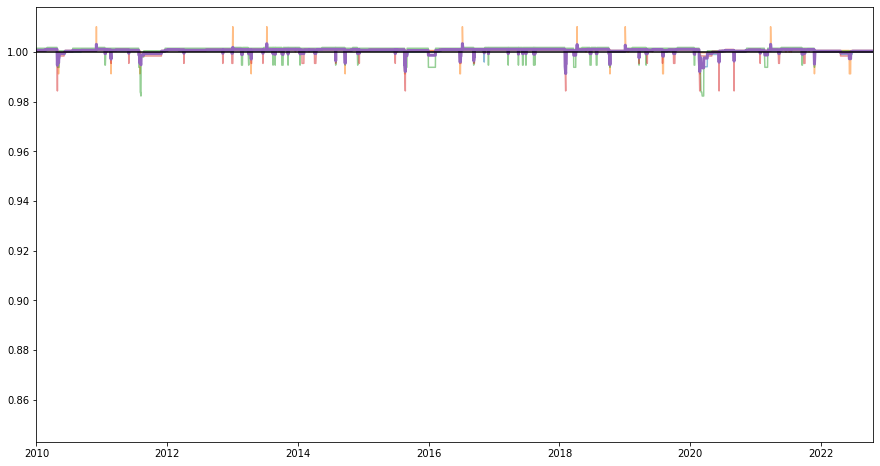

In [45]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

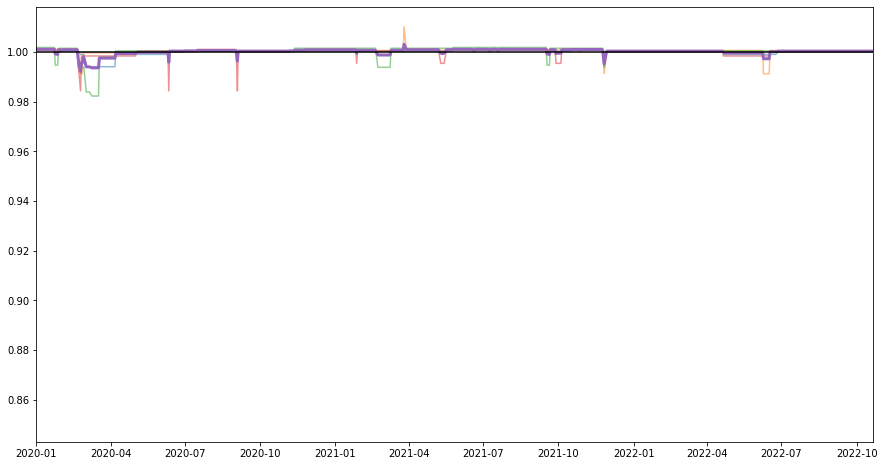

In [46]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);
plt.axhline(y = 1, color='k');

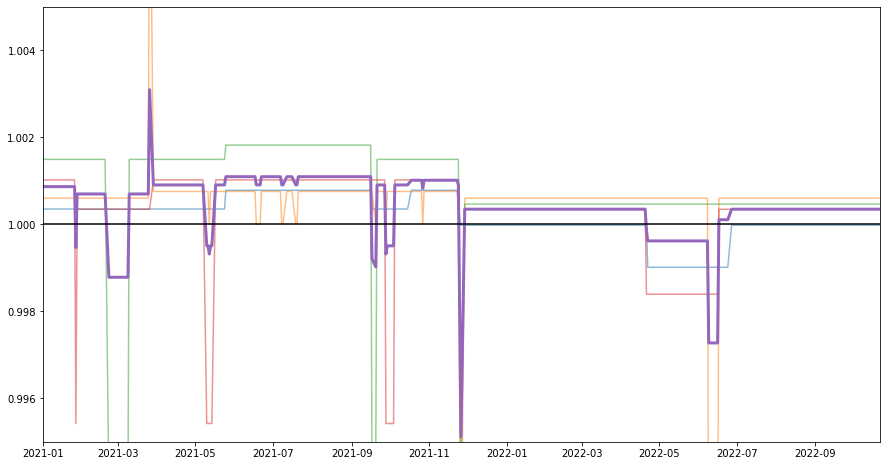

In [47]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y = 1, color='k')
plt.xlim(pd.to_datetime('2021-01-01'), TODAY)
plt.ylim([0.995, 1.005]);


In [48]:
df = df[df.index >= pd.to_datetime('1970-01-01')]

In [49]:
df.mean_exp.quantile(np.linspace(0, 1, 8))

0.000000    0.942965
0.142857    1.000349
0.285714    1.000611
0.428571    1.000868
0.571429    1.000926
0.714286    1.000977
0.857143    1.001096
1.000000    1.004122
Name: mean_exp, dtype: float64

In [50]:
try:
    df['state'] = pd.qcut(
        df.mean_exp, N_STATES, retbins=False, duplicates='drop', labels=range(N_STATES))
except ValueError:
    df['state'] = pd.qcut(
        df.mean_exp, N_STATES, retbins=False, duplicates='drop', labels=range(N_STATES - 1))

In [51]:
df.state.value_counts()

6    2285
1    2125
3    2035
0    1667
4    1598
5    1350
2    1230
7    1031
Name: state, dtype: int64

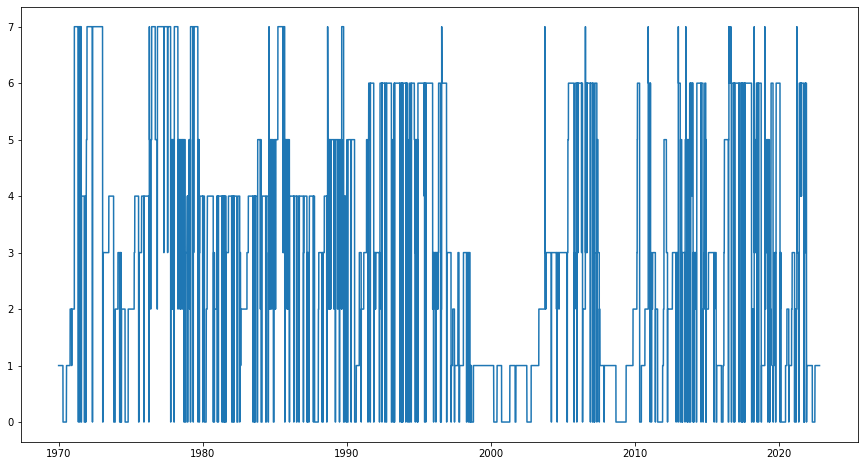

In [52]:
plt.figure(figsize=[15, 8])
plt.plot(df.state);

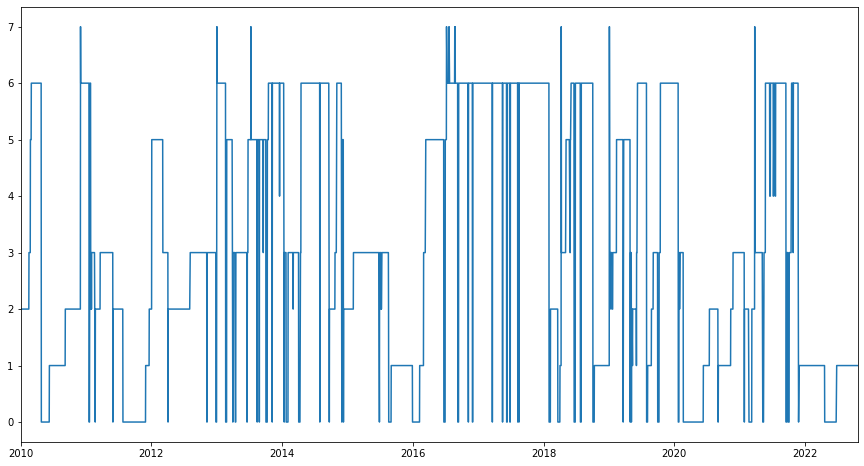

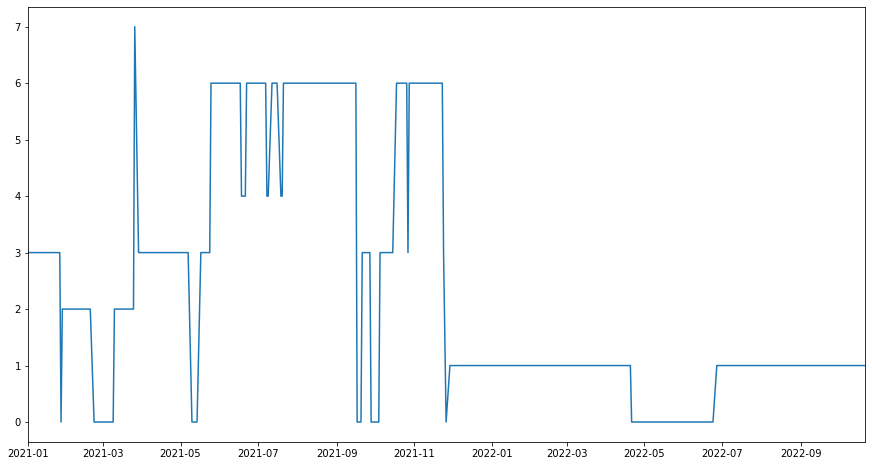

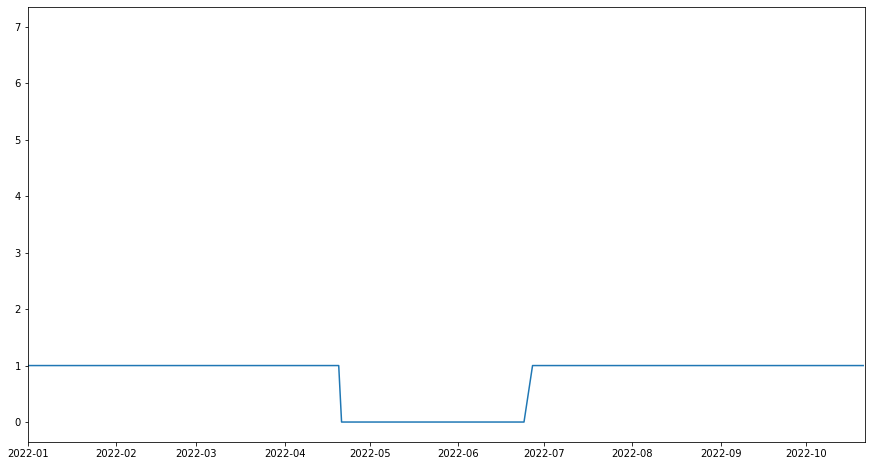

In [53]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2021-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2022-01-01'), TODAY);

In [54]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')

In [55]:
TODAY

datetime.datetime(2022, 10, 21, 15, 11, 54, 916175)